In [2]:
#Qn 1
import numpy as np
Q = np.array(
	[[0,1,np.nan],
	[1,np.nan,1],
	[np.nan, 1,2]])
lambda_ = 0.001
n_factors = 1
m,n = Q.shape
n_iterations = 10000
W = 1-(np.isnan(Q))*1
Q = np.nan_to_num(Q)

X = 5*np.random.rand(m,n_factors)
Y = 5*np.random.rand(n_factors,n)

def get_error(Q,X,Y,W):
    return np.sum((W*(Q - np.dot(X,Y)))**2)

for ii in range(n_iterations):
    for a in range(m):
        YW = np.dot(Y,np.diag(W[a,:]))
        X[a:,] = np.linalg.solve(np.dot(YW, YW.T) + lambda_ * np.eye(n_factors),
        	np.dot(Y,Q[a,:].T)).T
    for i in range(m):
        WX = np.dot(np.diag(W[:,i]),X)
        Y[:,i] = np.linalg.solve(np.dot(WX.T, WX) + lambda_ * np.eye(n_factors),
        	np.dot(X.T,Q[:,i]))
    if ii % 1000 == 0:
    	print(get_error(Q,X,Y,W))
Q_hat = np.dot(X,Y)
print('Error of rated movies: {}'.format(get_error(Q,X,Y,W)))
print('__________A_______\n')
print(Q_hat)
print(('_________U________\n'))
print(X)
print('__________V_______\n')
print(Y)

0.7515019424333431
0.634544123068307
0.6345432175457185
0.6345430999934103
0.6345430798322015
0.6345430761873623
0.6345430755219749
0.6345430754002869
0.6345430753780252
0.6345430753739522
Error of rated movies: 0.6345430753732073
__________A_______

[[0.48704756 0.61089466 0.95497563]
 [0.61089466 0.76623376 1.1978081 ]
 [0.95497563 1.1978081  1.87246283]]
_________U________

[[0.69788791]
 [0.87534777]
 [1.36837959]]
__________V_______

[[0.69788795 0.87534782 1.36837968]]


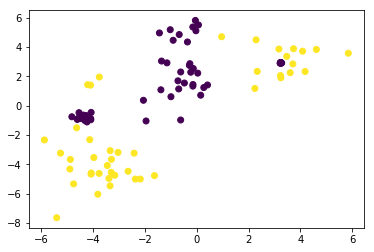

In [4]:
#Qn 2
import matplotlib.pyplot as plt
%matplotlib inline
csv = 'https://www.dropbox.com/s/wt45tvn9ig3o7vu/kernel.csv?dl=1'
data = np.genfromtxt(csv,delimiter =',')
X = data[:,1:]
Y = data[:,0]
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

In [5]:
#Qn 2a
from sklearn.svm import SVC
model = SVC(kernel='rbf', gamma=0.5)
model.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

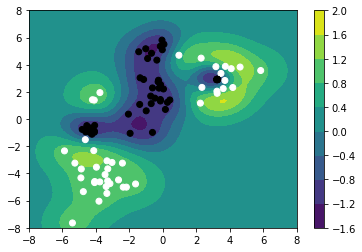

In [6]:
#Qn 2b
def decision(x1,x2,model):
    x = np.array([[x1,x2],[0,0]])
    value,_ = model.decision_function(x)
    return value
#Qn 2c
vdecision = np.vectorize(decision,excluded=[])
x1list = np.linspace(-8.0,8.0,100)
x2list = np.linspace(-8.0,8.0,100)
X1, X2 = np.meshgrid(x1list,x2list)
z = vdecision(X1,X2,model)
cp = plt.contourf(X1,X2,z)
plt.colorbar(cp)
plt.scatter(X[:,0],X[:,1],c=Y, cmap='gray')
plt.show()


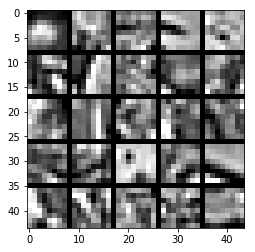

In [13]:
#Qn 3
#utils link 'https://www.dropbox.com/s/e7opv0iybk4gr7a/utils.py?dl=1'
#image link 'https://www.dropbox.com/s/c9crd7fjk1523wh/images.npy?dl=1'
#Note that jupyter notebook can't read directly for some reason, copied all functions here. 
from numpy.linalg import norm
import numpy
from numpy.random import rand
from scipy.optimize import fmin_l_bfgs_b as minimize

def sigmoid(x):
    return 1/(1+numpy.exp(-x))


def unravelParameters(theta,hiddenSize,visibleSize):
    W1 = theta[0:hiddenSize*visibleSize].reshape(visibleSize,hiddenSize)
    W2 = theta[hiddenSize*visibleSize:2*hiddenSize*visibleSize].reshape(hiddenSize,visibleSize)
    b1 = theta[2*hiddenSize*visibleSize:2*hiddenSize*visibleSize+hiddenSize].reshape(hiddenSize,1)
    b2 = theta[2*hiddenSize*visibleSize+hiddenSize:].reshape(visibleSize,1)
    return W1,W2,b1,b2
    


def ravelParameters(W1,W2,b1,b2):
    return numpy.concatenate((W1.ravel(),W2.ravel(),b1.ravel(),b2.ravel()))


def initializeParameters(hiddenSize,visibleSize):
    r = numpy.sqrt(6)/numpy.sqrt(hiddenSize+visibleSize+1)
    W1 = rand(visibleSize,hiddenSize)*2*r-r
    W2 = rand(hiddenSize,visibleSize)*2*r-r
    b1 = numpy.zeros((hiddenSize,1))
    b2 = numpy.zeros((visibleSize,1))
    theta = ravelParameters(W1,W2,b1,b2)    
    return theta



def computeNumericalGradient(J,theta,indices):
    numgrad = numpy.zeros(numpy.shape(theta))
    EPSILON = 10**(-4)
    for i in indices:
        epsi = numpy.zeros(numpy.shape(theta))
        epsi[i] = EPSILON/2
        numgrad[i] = (J(theta+epsi)-J(theta-epsi))/EPSILON
    return numgrad


def normalize(data):
    truncMean = numpy.array([numpy.mean(data,axis=1)]).T
    truncDev = 3*numpy.std(data)
    data = data-truncMean
    data = numpy.fmax(numpy.fmin(data,truncDev),-truncDev)/truncDev    
    data = (data+1)*0.4+0.1
    return data


def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar
def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    """
    Transform an array with one flattened image per row, into an array in
    which images are reshaped and layed out like tiles on a floor.

    This function is useful for visualizing datasets whose rows are images,
    and also columns of matrices for transforming those rows
    (such as the first layer of a neural net).

    :type X: a 2-D ndarray or a tuple of 4 channels, elements of which can
    be 2-D ndarrays or None;
    :param X: a 2-D array in which every row is a flattened image.

    :type img_shape: tuple; (height, width)
    :param img_shape: the original shape of each image

    :type tile_shape: tuple; (rows, cols)
    :param tile_shape: the number of images to tile (rows, cols)

    :param output_pixel_vals: if output should be pixel values (i.e. int8
    values) or floats

    :param scale_rows_to_unit_interval: if the values need to be scaled before
    being plotted to [0,1] or not


    :returns: array suitable for viewing as an image.
    (See:`Image.fromarray`.)
    :rtype: a 2-d array with same dtype as X.

    """

    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2

    # The expression below can be re-written in a more C style as
    # follows :
    #
    # out_shape    = [0,0]
    # out_shape[0] = (img_shape[0]+tile_spacing[0])*tile_shape[0] -
    #                tile_spacing[0]
    # out_shape[1] = (img_shape[1]+tile_spacing[1])*tile_shape[1] -
    #                tile_spacing[1]
    out_shape = [
        (ishp + tsp) * tshp - tsp
        for ishp, tshp, tsp in zip(img_shape, tile_shape, tile_spacing)
    ]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output numpy ndarray to store the image
        if output_pixel_vals:
            out_array = numpy.zeros((out_shape[0], out_shape[1], 4),
                                    dtype='uint8')
        else:
            out_array = numpy.zeros((out_shape[0], out_shape[1], 4),
                                    dtype=X.dtype)

        #colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                dt = out_array.dtype
                if output_pixel_vals:
                    dt = 'uint8'
                out_array[:, :, i] = numpy.zeros(
                    out_shape,
                    dtype=dt
                ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(
                    X[i], img_shape, tile_shape, tile_spacing,
                    scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        dt = X.dtype
        if output_pixel_vals:
            dt = 'uint8'
        out_array = numpy.zeros(out_shape, dtype=dt)

        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    this_x = X[tile_row * tile_shape[1] + tile_col]
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(
                            this_x.reshape(img_shape))
                    else:
                        this_img = this_x.reshape(img_shape)
                    # add the slice to the corresponding position in the
                    # output array
                    c = 1
                    if output_pixel_vals:
                        c = 255
                    out_array[
                        tile_row * (H + Hs): tile_row * (H + Hs) + H,
                        tile_col * (W + Ws): tile_col * (W + Ws) + W
                    ] = this_img * c
        return out_array


nV = 8*8 # number of visible units
nH = 25 # number of hidden units
dW = 0.0001 # weight decay term
sW = 3 # sparsity penalty term
npy = 'images.npy'
X = normalize(np.load(npy))
plt.imshow(tile_raster_images(X=X, img_shape=(8,8), tile_shape=(5,5), tile_spacing=(1,1)), cmap='gray')
plt.show()

In [14]:
#Qn 3a
def sparseAutoencoderCost(theta,nV,nH,dW,sW,X):
    W1,W2,b1,b2 = unravelParameters(theta,nH,nV)
    n = X.shape[0]
    z2 = np.dot(X, W1) + b1.T
    a2 = sigmoid(z2)
    z3 = np.dot(a2, W2) + b2.T 
    a3 = sigmoid(z3)
    eps = a3 - X
    loss = (norm(eps) ** 2) / 2 / n
    decay = (norm(W1) ** 2 + norm(W2) ** 2) / 2
    # Compute sparsity terms and total cost
    rho = 0.01
    a2mean = np.mean(a2,axis=0).reshape(nH,1)
    kl = np.sum(rho*np.log(rho/a2mean)+
    (1-rho)*np.log((1-rho)/(1-a2mean)))
    dkl = -rho/a2mean+(1-rho)/(1-a2mean)
    cost = loss + dW*decay + sW*kl
    d3 = eps  *a3 * (1-a3)
    d2 = (sW*dkl.T+np.dot(d3,W2.T))*a2*(1-a2)
    W1grad = (np.dot(X.T, d2)) /n + dW * W1
    W2grad = (np.dot(a2.T, d3)) / n + dW * W2
    b1grad = np.dot(d2.T, np.ones(n)) / n
    b2grad = np.dot(d3.T, np.ones(n)) / n
    grad = ravelParameters(W1grad,W2grad,b1grad,b2grad)
    grad = ravelParameters(W1grad,W2grad,b1grad,b2grad)
    print(' .',end="")
    return cost,grad

theta = initializeParameters(nH,nV)
cost,grad = sparseAutoencoderCost(theta,nV,nH,dW,sW,X)

 .

In [16]:
#Q3b
print('\n Comparing numerical gradient with backprop gradient')
num_coords = 5
indices = np.random.choice(theta.size,num_coords, replace=False)
numgrad = computeNumericalGradient(lambda t:
                                   sparseAutoencoderCost(t,nV,nH,dW,sW,X)[0],theta,indices)
subnumgrad=numgrad[indices]
subgrad=grad[indices]
diff = norm(subnumgrad-subgrad)/norm(subnumgrad+subgrad)
print('\n', np.array([subnumgrad,subgrad]).T)
print('The relative difference is ', diff)


 Comparing numerical gradient with backprop gradient
 . . . . . . . . . .
 [[-8.36873355e-03 -8.36873357e-03]
 [-6.10762712e-04 -6.10762706e-04]
 [ 2.35801721e-03  2.35801720e-03]
 [ 3.38225291e-03  3.38225287e-03]
 [ 1.00205294e+00  1.00205294e+00]]
The relative difference is  1.082112485421587e-10



Training neural network
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

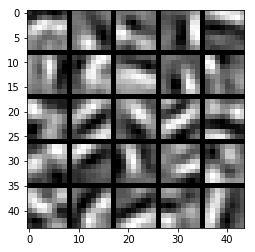

In [17]:
#Qn 3c
print('\nTraining neural network')
theta = initializeParameters(nH,nV)
opttheta,cost,messages = minimize(sparseAutoencoderCost,
theta,fprime=None,maxiter=400,args=(nV,nH,dW,sW,X))
W1,W2,b1,b2 = unravelParameters(opttheta,nH,nV)
plt.imshow(tile_raster_images(X=W1.T,
img_shape=(8,8),tile_shape=(5,5),
tile_spacing=(1,1)),cmap='gray')
plt.show()

#Qn 4a

    You commented that MLE is used to discuss the probability of word w so that the probability that a document is generated is maximized. Here, the operative word being whether a document is generated, does there exist the probability that a document is not generated? If so, how do you define the maximization of the generation?
    In your question, you asked if W =  collection of words in document S or W = collection of words in the dictionary. However, you did not define the term 'dictionary' in slides 13 - 14.


So there are two ways to interpret this question:

    Document S, as stated in slide 13, was generated one word at a time. Each word was generated independently from the other, such that the probability of a word being x is 1/n, where n is the number of words. A dictionary here is treated as a universal collection of words, with each word being defined by a probability of it occurring.
        Since we have already defined each word as having an equal probability of appearing, thus there would be no difference between the generation of each word. Thus, it does not matter that W is either collection because they refer to the same thing, that is, the maximum likelihood of a word appearing is always 1/n for either a dictionary or a document
    Document S is a sample document. The words generated are dependent on the previous word, and the new document is modelled off previous documents. This is the current practice for a word-generating model.  In this case, we can see that it is imperative that W denotes the universal collection of words we call a dictionary. Because the MLE of a word is dependent on the frequency of the words in the previous documents that the model has been trained on. Thus, a model using document S is more likely to generate certain words, such as the connecting words 'and, to,' and other prepositions as compared to obscure words like 'definition'. 

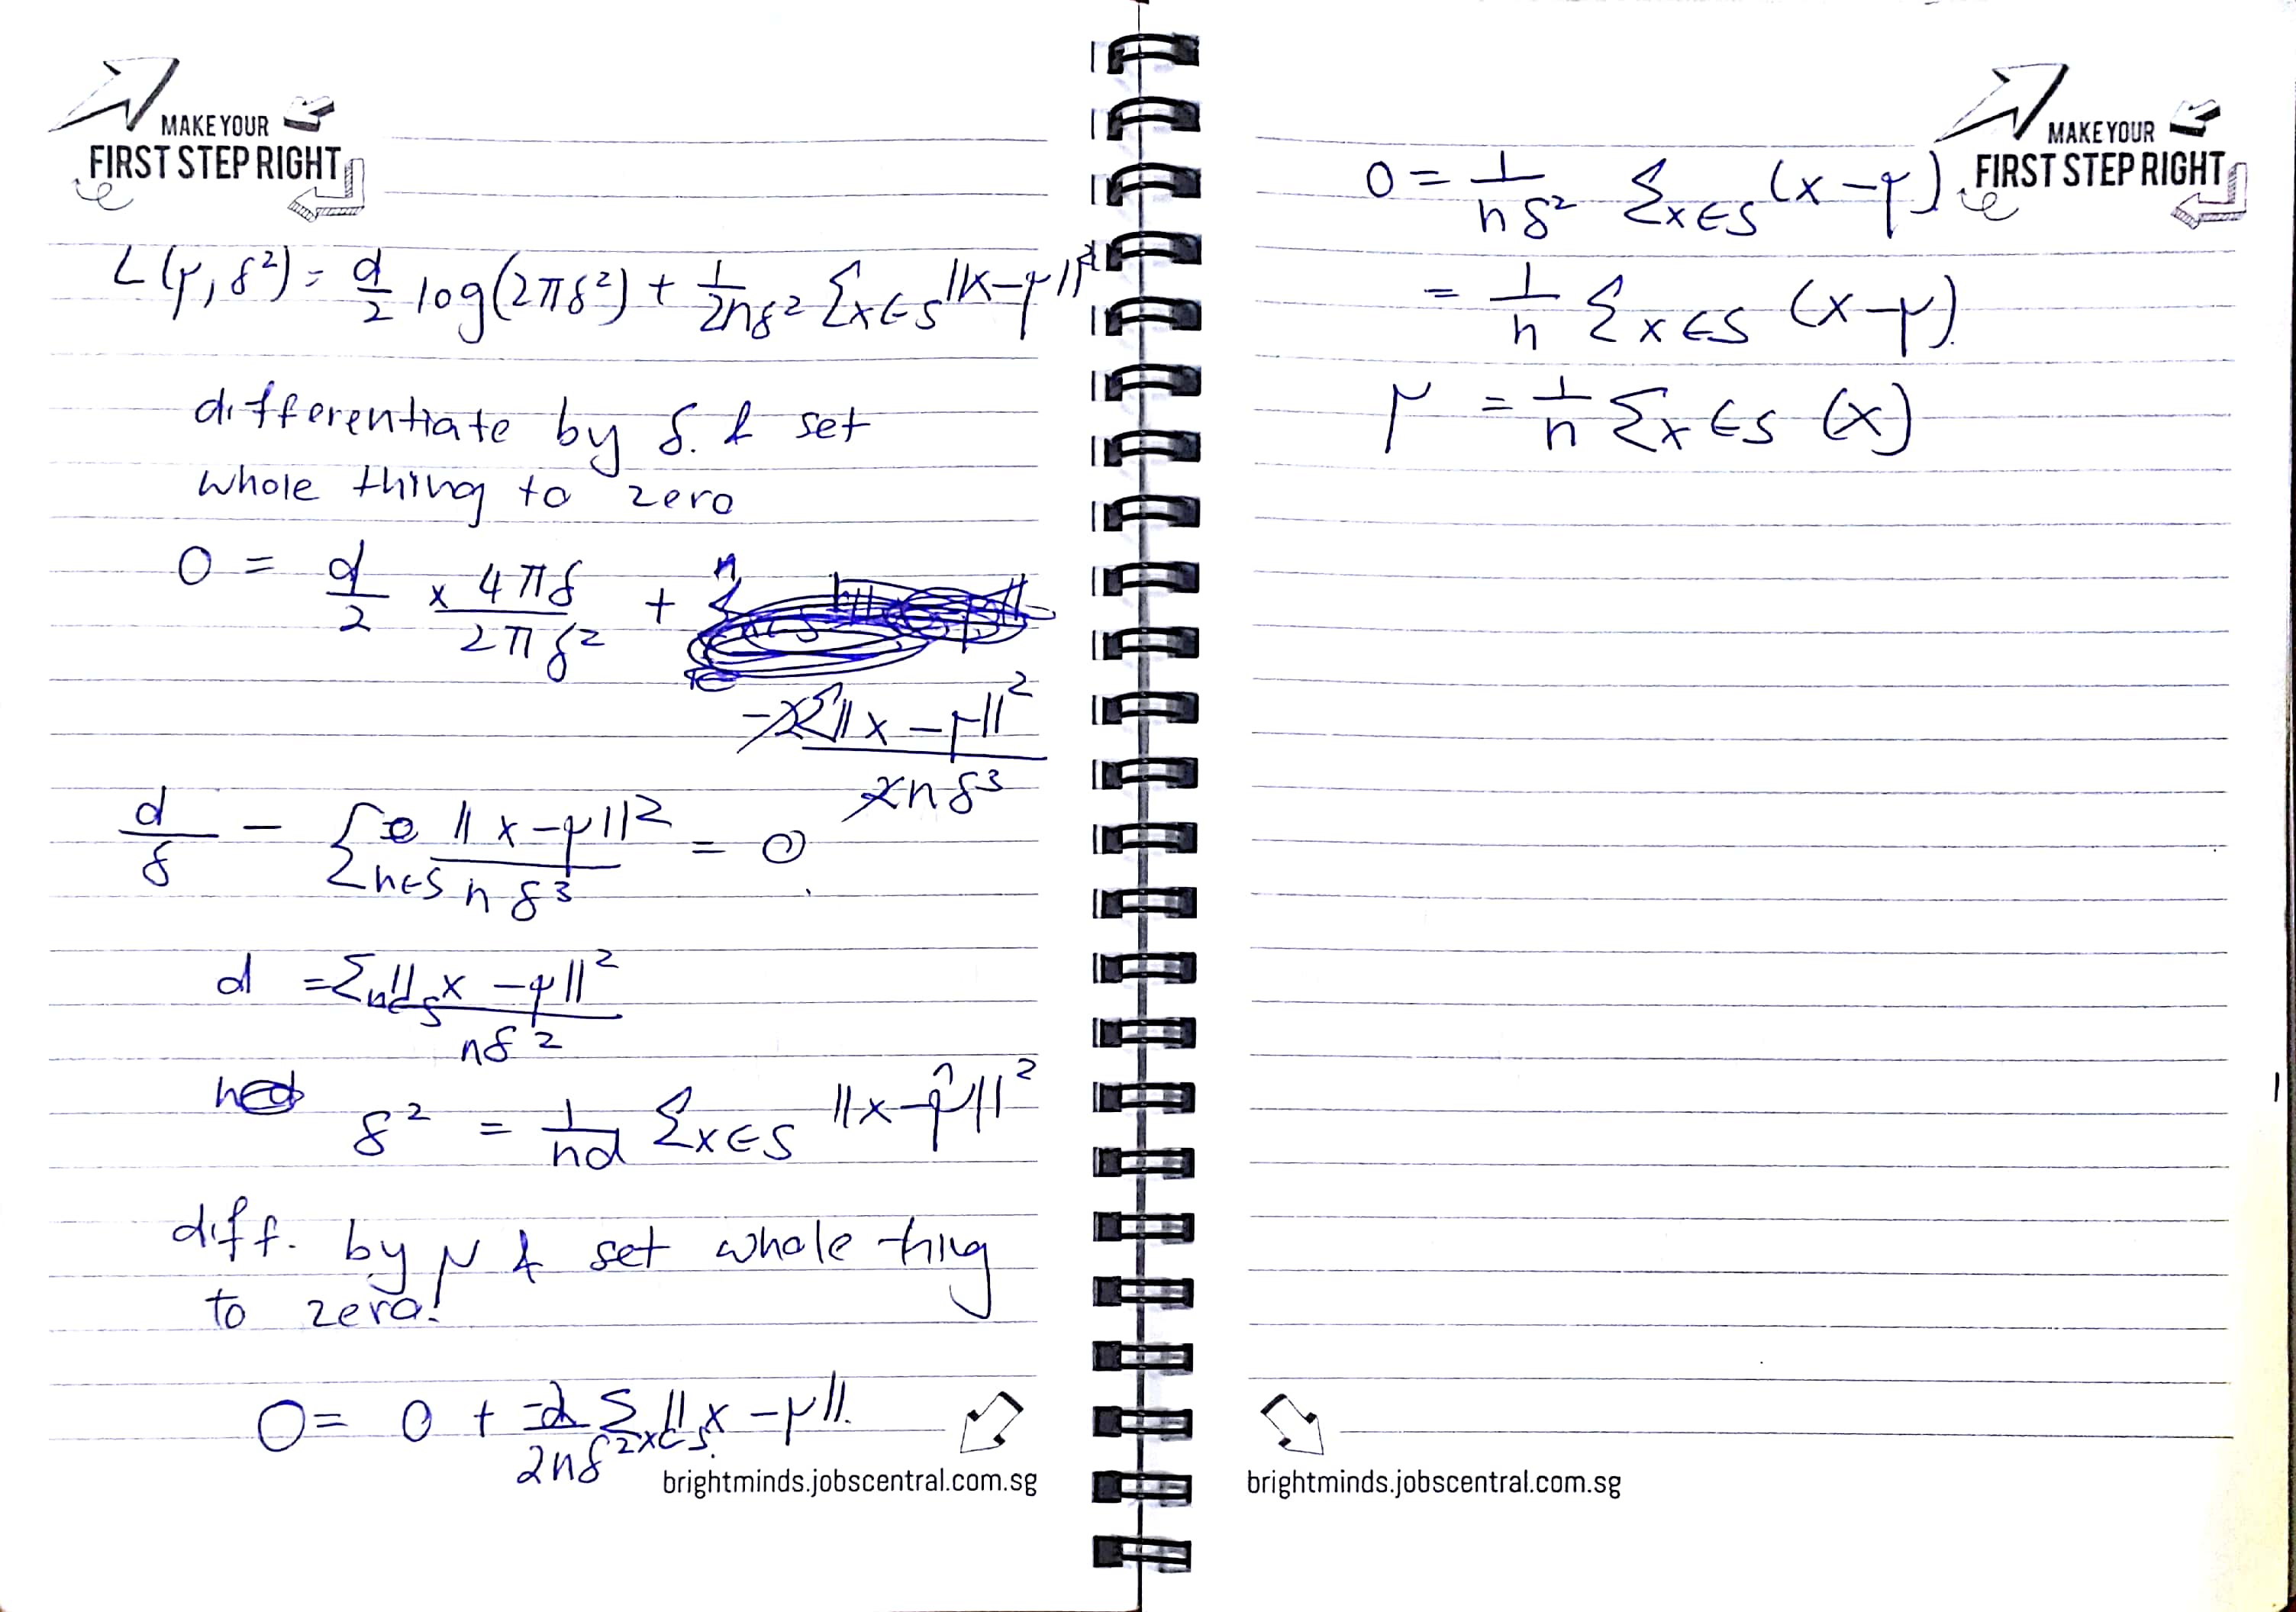
#Qn 4b